# This is the notebook for Midterm project of MLZoomCamp

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

### Problem description

We use a data set (https://www.openml.org/search?type=data&sort=runs&status=any&id=40536) to try to predict whether there will be match on a dating service, supposedly run on a website, where users can create profiles, fill out a questionaire about interest, evalute other profiles and then service would make a recommendation, should there be a match between profiles or not.

The dataset is from an experiment on speed dating, and was intended for analysis purposes, thus so in order to make realistic application, we have to decide how/if adapt some parameters of a dataset, such as "decision" and "decision_o", i.e. whether each particiapnt made decison match/no_match on the night of the event. These parameters may not be viable parameters of the application. However, due to model precsion problem we would still require some data from portential partner side, some small amount of evaluations of potential partner of a requester of service.

This is a classification problem with prediction of "match" (yes/no) variable.

Attribute Information: (from URL above)

 * gender: Gender of self  
 * age: Age of self  
 * age_o: Age of partner  
 * d_age: Difference in age  
 * race: Race of self  
 * race_o: Race of partner  
 * samerace: Whether the two persons have the same race or not.  
 * importance_same_race: How important is it that partner is of same race?  
 * importance_same_religion: How important is it that partner has same religion?  
 * field: Field of study  
 * pref_o_attractive: How important does partner rate attractiveness  
 * pref_o_sinsere: How important does partner rate sincerity  
 * pref_o_intelligence: How important does partner rate intelligence  
 * pref_o_funny: How important does partner rate being funny  
 * pref_o_ambitious: How important does partner rate ambition  
 * pref_o_shared_interests: How important does partner rate having shared interests  
 * attractive_o: Rating by partner (about me) at night of event on attractiveness  
 * sincere_o: Rating by partner (about me) at night of event on sincerity  
 * intelligence_o: Rating by partner (about me) at night of event on intelligence  
 * funny_o: Rating by partner (about me) at night of event on being funny  
 * ambitous_o: Rating by partner (about me) at night of event on being ambitious  
 * shared_interests_o: Rating by partner (about me) at night of event on shared interest  
 * attractive_important: What do you look for in a partner - attractiveness  
 * sincere_important: What do you look for in a partner - sincerity  
 * intellicence_important: What do you look for in a partner - intelligence  
 * funny_important: What do you look for in a partner - being funny  
 * ambtition_important: What do you look for in a partner - ambition  
 * shared_interests_important: What do you look for in a partner - shared interests  
 * attractive: Rate yourself - attractiveness  
 * sincere: Rate yourself - sincerity   
 * intelligence: Rate yourself - intelligence   
 * funny: Rate yourself - being funny   
 * ambition: Rate yourself - ambition  
 * attractive_partner: Rate your partner - attractiveness  
 * sincere_partner: Rate your partner - sincerity   
 * intelligence_partner: Rate your partner - intelligence   
 * funny_partner: Rate your partner - being funny   
 * ambition_partner: Rate your partner - ambition   
 * shared_interests_partner: Rate your partner - shared interests  
 * sports: Your own interests [1-10]  
 * tvsports  
 * exercise  
 * dining  
 * museums  
 * art  
 * hiking  
 * gaming  
 * clubbing  
 * reading  
 * tv  
 * theater  
 * movies  
 * concerts  
 * music  
 * shopping  
 * yoga  
 * interests_correlate: Correlation between participant’s and partner’s ratings of interests.  
 * expected_happy_with_sd_people: How happy do you expect to be with the people you meet during the speed-dating event?  
 * expected_num_interested_in_me: Out of the 20 people you will meet, how many do you expect will be interested in dating you?  
 * expected_num_matches: How many matches do you expect to get?  
 * like: Did you like your partner?  
 * guess_prob_liked: How likely do you think it is that your partner likes you?   
 * met: Have you met your partner before?  
 * decision: Decision at night of event.
 * decision_o: Decision of partner at night of event.  
 * match: Match (yes/no)

### Import Data

In [2]:
from scipy.io.arff import loadarff 
raw_data = loadarff('speeddating.arff')
df_raw = pd.DataFrame(raw_data[0])
cols = df_raw.columns

In [3]:
import arff
dataset = arff.load(open('speeddating.arff', 'r'))
data = np.array(dataset['data'])

#### Treat arff data to make it conform with pandas

In [4]:
df = pd.DataFrame(data,columns = cols)

##### Explore

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df.describe()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
count,8378,8378.0,8378,8283.0,8274.0,8378.0,8378,8315,8305,8378,8299.0,8299.0,8378,8378,8315,8289.0,8289.0,8289.0,8280.0,8271.0,8249.0,8378,8378,8378,8378,8378,8378,8166.0,8091.0,8072.0,8018.0,7656.0,7302.0,8378,8378,8378,8378,8378,8378,8299.0,8299.0,8299.0,8289.0,8279.0,8257.0,8378,8378,8378,8378,8378,8378,8273.0,8273.0,8273.0,8273.0,8273.0,8378,8378,8378,8378,8378,8176.0,8101.0,8082.0,8028.0,7666.0,7311.0,8378,8378,8378,8378,8378,8378,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8299.0,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8220.00,8378,8277.0,1800.0,7205.0,8378,8378,8378,8138.0,8069.0,8378,8378,8003.0,8378,8378,8378
unique,2,21.0,2,24.0,24.0,35.0,4,5,5,2,11.0,10.0,3,3,259,94.0,78.0,65.0,71.0,82.0,85.0,3,3,3,3,3,3,18.0,14.0,17.0,17.0,15.0,15.0,3,3,3,3,3,3,94.0,78.0,65.0,71.0,82.0,85.0,3,3,3,3,3,3,9.0,9.0,9.0,8.0,9.0,3,3,3,3,3,17.0,14.0,17.0,16.0,15.0,15.0,3,3,3,3,3,3,10.0,10.0,10.0,10.0,11.0,11.0,11.0,12.0,11.0,11.0,10.0,11.0,10.0,11.0,10.0,10.0,11.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,155.00,3,10.0,18.0,17.0,3,3,3,18.0,19.0,3,3,7.0,2,2,2
top,1,21.0,male,27.0,27.0,1.0,[2-3],European/Caucasian-American,European/Caucasian-American,0,1.0,1.0,[2-5],[0-1],Business,20.0,20.0,20.0,20.0,10.0,10.0,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6.0,8.0,8.0,7.0,7.0,5.0,[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],20.0,20.0,20.0,20.0,10.0,10.0,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],7.0,9.0,8.0,8.0,8.0,[6-8],[9-10],[6-8],[6-8],[6-8],6.0,8.0,8.0,7.0,7.0,5.0,[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],8.0,1.0,8.0,8.0,7.0,8.0,8.0,1.0,8.0,9.0,6.0,7.0,8.0,7.0,10.0,7.0,1.0,[6-8],[0-5],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],[6-8],[6-8],[0-5],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],0.31,[0-0.33],5.0,3.0,2.0,[5-6],[0-3],[0-2],7.0,5.0,[6-8],[5-6],0.0,0,0,0
freq,7330,968.0,4194,1059.0,1059.0,1548.0,2406,4727,4722,5062,2798.0,3032.0,3104,3111,521,1670.0,2268.0,2711.0,2233.0,2006.0,2001.0,3010,3820,4272,3870,6680,6085,1655.0,2045.0,2198.0,1657.0,1679.0,1462.0,4537,5192,5379,4645,4613,4690,1671.0,2269.0,2715.0,2237.0,2009.0,2003.0,3019,3821,4276,3874,6680,6083,2914.0,2393.0,2274.0,2872.0,2028.0,6231,4084,4929,4244,4407,1658.0,2046.0,2199.0,1657.0,1681.0,1465.0,4545

In [6]:
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,35.0,20.0,20.0,20.0,0.0,5.0,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6.0,8.0,8.0,8.0,8.0,6.0,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],6.0,9.0,7.0,7.0,6.0,5.0,[6-8],[9-10],[6-8],[6-8],[6-8],[0-5],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.14,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,60.0,0.0,0.0,40.0,0.0,0.0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7.0,8.0,10.0,7.0,7.0,5.0,[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],7.0,8.0,7.0,8.0,5.0,6.0,[6-8],[6-8],[6-8],[6-8],[0-5],[6-8],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.54,[0.33-1],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,[2-5],[2-5],Law,19.0,18.0,19.0,18.0,14.0,12.0,[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],10.0,10.0,10.0,10.0,10.0,10.0,[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],5.0,8.0,9.0,8.0,5.0,7.0,[0-5],[6-8],[9-10],[6-8],[0-5],[6-8],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.16,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,None,[6-8],[0-4],1.0,1,1,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,[2-5],[2-5],Law,30.0,5.0,15.0,40.0,5.0,5.0,

In [7]:
cols_list = list(cols)
print(cols_list)

['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age', 'race', 'race_o', 'samerace', 'importance_same_race', 'importance_same_religion', 'd_importance_same_race', 'd_importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'attractive', 'sincere', '

In [8]:
missing_values = []
for col in cols:
    missing_values.append(len(df[df[col].isnull()][col]))

In [9]:
print(missing_values)

[0, 0, 0, 95, 104, 0, 0, 63, 73, 0, 79, 79, 0, 0, 63, 89, 89, 89, 98, 107, 129, 0, 0, 0, 0, 0, 0, 212, 287, 306, 360, 722, 1076, 0, 0, 0, 0, 0, 0, 79, 79, 79, 89, 99, 121, 0, 0, 0, 0, 0, 0, 105, 105, 105, 105, 105, 0, 0, 0, 0, 0, 202, 277, 296, 350, 712, 1067, 0, 0, 0, 0, 0, 0, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 101, 6578, 1173, 0, 0, 0, 240, 309, 0, 0, 375, 0, 0, 0]


In [10]:
df_missing_values = pd.DataFrame([missing_values], columns = cols_list)

In [11]:
df_missing_values

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,0,0,95,104,0,0,63,73,0,79,79,0,0,63,89,89,89,98,107,129,0,0,0,0,0,0,212,287,306,360,722,1076,0,0,0,0,0,0,79,79,79,89,99,121,0,0,0,0,0,0,105,105,105,105,105,0,0,0,0,0,202,277,296,350,712,1067,0,0,0,0,0,0,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158,0,101,6578,1173,0,0,0,240,309,0,0,375,0,0,0


In [12]:
df.dtypes

has_null                           object
wave                               object
gender                             object
age                                object
age_o                              object
d_age                              object
d_d_age                            object
race                               object
race_o                             object
samerace                           object
importance_same_race               object
importance_same_religion           object
d_importance_same_race             object
d_importance_same_religion         object
field                              object
pref_o_attractive                  object
pref_o_sincere                     object
pref_o_intelligence                object
pref_o_funny                       object
pref_o_ambitious                   object
pref_o_shared_interests            object
d_pref_o_attractive                object
d_pref_o_sincere                   object
d_pref_o_intelligence             

##### Clean data for the type and replace nan

In [13]:
df_clean = df.copy()
for col in cols:
    if pd.api.types.is_object_dtype(df_clean[col]):
        try:
            df_clean[col] = df_clean[col].astype(float)
            df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
            #print(col,'scs-num')
        except ValueError:
            try:
                df_clean[col] = df_clean[col].astype(str)
                df_clean[col] = df_clean[col].fillna('unknown')
                #print(col,'scs-str')
            except ValueError:
                pass

In [14]:
df_clean.dtypes

has_null                           float64
wave                               float64
gender                              object
age                                float64
age_o                              float64
d_age                              float64
d_d_age                             object
race                                object
race_o                              object
samerace                           float64
importance_same_race               float64
importance_same_religion           float64
d_importance_same_race              object
d_importance_same_religion          object
field                               object
pref_o_attractive                  float64
pref_o_sincere                     float64
pref_o_intelligence                float64
pref_o_funny                       float64
pref_o_ambitious                   float64
pref_o_shared_interests            float64
d_pref_o_attractive                 object
d_pref_o_sincere                    object
d_pref_o_in

In [15]:
df_clean.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0.0,2.0,4.0,[2-5],[2-5],Law,35.0,20.0,20.0,20.0,0.0,5.0,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6.0,8.0,8.0,8.0,8.0,6.0,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],6.0,9.0,7.0,7.0,6.0,5.0,[6-8],[9-10],[6-8],[6-8],[6-8],[0-5],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.14,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,6.000000,[6-8],[5-6],0.0,1.0,0.0,0.0
1,0.0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0.0,2.0,4.0,[2-5],[2-5],Law,60.0,0.0,0.0,40.0,0.0,0.0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7.0,8.0,10.0,7.0,7.0,5.0,[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],7.0,8.0,7.0,8.0,5.0,6.0,[6-8],[6-8],[6-8],[6-8],[0-5],[6-8],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.54,[0.33-1],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,5.000000,[6-8],[5-6],1.0,1.0,0.0,0.0
2,1.0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1.0,2.0,4.0,[2-5],[2-5],Law,19.0,18.0,19.0,18.0,14.0,12.0,[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],10.0,10.0,10.0,10.0,10.0,10.0,[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],15.0,20.0,20.0,15.0,15.0,15.0,[0-15],[16-20],[16-20],[0-15],[0-15],[0-15],6.0,8.0,8.0,8.0,7.0,[6-8],[6-8],[6-8],[6-8],[6-8],5.0,8.0,9.0,8.0,5.0,7.0,[0-5],[6-8],[9-10],[6-8],[0-5],[6-8],9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.16,[0-0.33],3.0,2.0,4.0,[0-4],[0-3],[3-5],7.0,5.207523,[6-8],[0-4],1.0,1.0,1.0,1.0
3,0.0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0.0,2.0

In [16]:
df_clean.describe()

,has_null,wave,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match
count,8378.00000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,0.87491,11.350919,26.358928,26.364999,4.185605,0.395799,3.784793,3.651645,22.495347,17.396867,20.270759,17.459714,10.685375,11.845930,6.190411,7.175256,7.369301,6.400599,6.778409,5.474870,22.514632,17.396389,20.265613,17.457043,10.682539,11.845111,7.084733,8.294935,7.704460,8.403965,7.578388,6.189995,7.175164,7.368597,6.400598,6.777524,5.474559,6.425232,4.575491,6.245813,7.783829,6.985781,6.714544,5.737077,3.881191,5.745993,7.678515,5.304133,6.776118,7.919629,6.825401,7.851066,5.631281,4.339197,0.196010,5.534131,5.570556,3.207814,6.134087,5.207523,0.049856,0.419909,0.419551,0.164717
std,0.33084,5.995903,3.546480,3.541458,4.596171,0.489051,2.832258,2.791978,12.502851,7.006484,6.746767,6.049825,6.087291,6.313565,1.925469,1.710499,1.521919,1.911629,1.715024,2.012929,12.528179,7.013394,6.750943,6.052827,6.088588,6.316038,1.387008,1.398611,1.554486,1.069839,1.767135,1.926513,1.711300,1.522814,1.912453,1.716119,2.014356,2.606645,2.788632,2.407425,1.746573,2.042532,2.252709,2.558059,2.608122,2.490391,1.997082,2.517181,2.224588,1.692888,2.146091,1.783358,2.596582,2.704767,0.300663,1.723574,2.207052,2.267192,1.814717,2.089919,0.275780,0.493573,0.493515,0.370947
min,0.00000,1.000000,18.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-0.830000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,7.000000,24.000000,24.000000,1.000000,0.000000,1.000000,1.000000,15.000000,15.000000,17.650000,15.000000,5.000000,10.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,15.000000,15.000000,17.650000,15.000000,5.000000,10.000000,6.000000,8.000000,7.000000,8.000000,7.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,2.000000,5.000000,7.000000,6.000000,5.000000,4.000000,2.000000,4.000000,7.000000,3.000000,5.000000,7.000000,5.000000,7.000000,4.000000,2.000000,-0.010000,5.000000,5.570556,2.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,11.000000,26.000000,26.000000,3.00000

##### Delete meta-data inapplicable in online service: wave(of participans study), has_null (as we replaced nulls)

In [17]:
del df_clean['has_null']
del df_clean['wave']
cols_list.remove('has_null')
cols_list.remove('wave')
cols = df_clean.columns

* Lets review target variable

Text(0.5, 1.0, 'Histogramm of match metric')

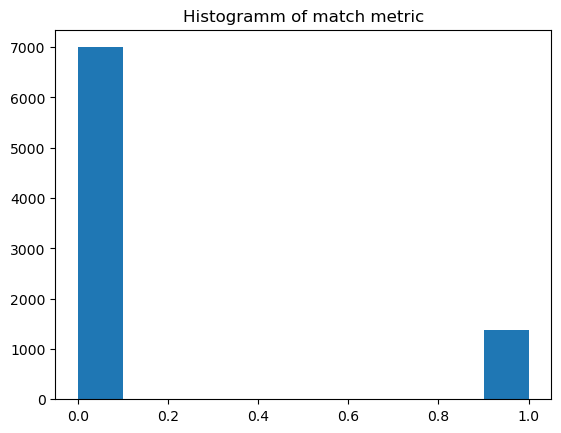

In [18]:
plt.hist(df_clean.match)
plt.title("Histogramm of match metric")

* Considering distribution, we have to be careful with false positive.

### Exploratory Data Analysis (EDA)

In [19]:
# we need a function to prepare data in order to test different compisition of features,
# given that some features are categorical, excluding/including such features will change DictVectorizer
# and effective number of features
# as inputs we have: dataframe, effective features, and indexes of datasets if thery were calculated beforehand
def prepare_data(df, cols, train_index = None, val_index = None, test_index = None):
    if (train_index is None) or (val_index is None) or (test_index is None):
        # in case indexes were not provided we apply train_test_split
        df_full_train, df_test = train_test_split(df[cols], test_size=0.2, random_state=1)
        df_train, df_val = train_test_split(df_full_train, test_size=0.2/(0.2+0.6), random_state=1)
        
        # remember the indexes of sets
        train_index = df_train.index
        val_index = df_val.index
        test_index = df_test.index

    # make index of full train    
    full_train_index = train_index.union(val_index)
    
    # fill out the new datasets
    df_full_train = df[cols].loc[full_train_index].reset_index(drop=True)    
    df_train = df[cols].loc[train_index].reset_index(drop=True)
    df_val = df[cols].loc[val_index].reset_index(drop=True)
    df_test = df[cols].loc[test_index].reset_index(drop=True)

    # get target values
    y_full_train = df_full_train.match.values
    y_train = df_train.match.values
    y_val = df_val.match.values
    y_test = df_test.match.values

    # delete target values from newly formed datasets
    del df_full_train['match']
    del df_train['match']
    del df_val['match']
    del df_test['match']

    # print the amount of samples
    print('Samples:','Train:',df_train.shape,'Validation:', df_val.shape,'Test:', df_test.shape)    
    
    # make a dictvectorizer object and prepare feature matrix
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    full_train_dicts = df_full_train.to_dict(orient='records')
    X_full_train = dv.transform(full_train_dicts)
    
    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    test_dicts = df_test.to_dict(orient='records')
    X_test = dv.transform(test_dicts)
    
    
    return (dv, 
           X_full_train,y_full_train, full_train_index,
           X_train,y_train,train_index, 
           X_val,y_val,val_index, 
           X_test,y_test,test_index)

In [20]:
(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_list)

Samples: Train: (5026, 120) Validation: (1676, 120) Test: (1676, 120)


* Let' Make a First approach analysis on importance of features using _DecisionTreeClassifier_

In [21]:
dt = DecisionTreeClassifier(max_depth=1,random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=1)

In [22]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- decision_o <= 0.50
|   |--- class: 0.0
|--- decision_o >  0.50
|   |--- class: 0.0



* The most important feature is a decision of a partner on the night of the event(speed-dating). If we want to create a dating web-site, usually we don't know beforhand what would be the decision of other partner. Event if this feature i the most important, we should exclude it if possible. Lets make further analysis using _RandomForestCalssifier_

In [23]:
rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
pd.options.display.max_rows = None
df_importances.sort_values(by=['importance'],ascending=False)

,feature,importance
181,decision_o,0.141119
180,decision,0.119829
9,attractive_o,0.021759
10,attractive_partner,0.016131
449,funny_o,0.015787
490,shared_interests_partner,0.015437
108,d_like=[0-5],0.015399
454,guess_prob_liked,0.012385
144,d_shared_interests_o=[0-5],0.012234
489,shared_interests_o,0.011978


* Lets calculate F1 score

In [24]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.9903846153846153
Val F1 score:  0.6683046683046683
Test F1 score:  0.6777251184834123


* Now we know importance of the features, but it seemt that our calssifier is overfitted due difference in F1 score. Lets strip down progressively our features. Lets exclude all categories that describes (i.e. starts with d_) difference between metrics of a user and potential partner, as this is a meta-information and may be redundant

In [25]:
cols_wo_d = []
for col in cols_list:
    if not col.startswith('d_'):
        cols_wo_d.append(col)

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d,train_index = train_index, val_index = val_index, test_index = test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
df_importances = pd.DataFrame(data={'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
df_importances.sort_values(by=['importance'],ascending=False)

Samples: Train: (5026, 64) Validation: (1676, 64) Test: (1676, 64)


,feature,importance
13,decision,0.205093
14,decision_o,0.201401
10,attractive_partner,0.026596
322,shared_interests_o,0.024589
323,shared_interests_partner,0.024542
9,attractive_o,0.023696
296,like,0.019129
282,funny_o,0.018764
4,ambitous_o,0.016881
287,guess_prob_liked,0.016712


In [26]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.9946140035906643
Val F1 score:  0.7881548974943052
Test F1 score:  0.8493723849372385


* We succeded in increasing F1 score on all datasets. We see also on feature analysis that the col of "field" is pretty useless, lets get rid of it.

In [27]:
cols_wo_d_wo_field = cols_wo_d.copy()
cols_wo_d_wo_field.remove('field')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d_wo_field,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
df_importances = pd.DataFrame(data={'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
df_importances.sort_values(by=['importance'],ascending=False)

Samples: Train: (5026, 63) Validation: (1676, 63) Test: (1676, 63)


,feature,importance
13,decision,0.264083
14,decision_o,0.239079
9,attractive_o,0.048251
10,attractive_partner,0.037680
63,shared_interests_partner,0.031928
62,shared_interests_o,0.022907
36,like,0.022561
23,funny_partner,0.021245
22,funny_o,0.018431
35,interests_correlate,0.011419


In [28]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.99880810488677
Val F1 score:  0.9669902912621359
Test F1 score:  0.9581749049429658


* Good results, let's now get rid of racial characteristics of user and partner due to ethical reasons

In [29]:
cols_wo_d_wo_field_wo_race = cols_wo_d_wo_field.copy()
cols_wo_d_wo_field_wo_race.remove('race')
cols_wo_d_wo_field_wo_race.remove('race_o')
cols_wo_d_wo_field_wo_race.remove('samerace')
cols_wo_d_wo_field_wo_race.remove('importance_same_race')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d_wo_field_wo_race,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
df_importances = pd.DataFrame(data={'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
df_importances.sort_values(by=['importance'],ascending=False)

Samples: Train: (5026, 59) Validation: (1676, 59) Test: (1676, 59)


,feature,importance
14,decision_o,0.266212
13,decision,0.221731
35,like,0.060444
10,attractive_partner,0.041046
48,shared_interests_o,0.021853
9,attractive_o,0.021429
22,funny_o,0.020329
27,guess_prob_liked,0.018612
49,shared_interests_partner,0.015159
23,funny_partner,0.014386


In [30]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.99880810488677
Val F1 score:  0.9298597194388778
Test F1 score:  0.9402697495183043


* Very impressive, now lets get rid of the most important features: decision: Decision at night of event. decision_o: Decision of partner at night of event.  


In [31]:
cols_wo_d_wo_field_wo_race_wo_dec = cols_wo_d_wo_field.copy()
cols_wo_d_wo_field_wo_race_wo_dec.remove('race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('race_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('samerace')
cols_wo_d_wo_field_wo_race_wo_dec.remove('importance_same_race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('decision')
cols_wo_d_wo_field_wo_race_wo_dec.remove('decision_o')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d_wo_field_wo_race_wo_dec,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
#df_importances = pd.DataFrame(data={'feature': dv.get_feature_names_out(), 'importance': rf.feature_importances_})
#df_importances.sort_values(by=['importance'],ascending=False)

Samples: Train: (5026, 57) Validation: (1676, 57) Test: (1676, 57)


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [32]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.961038961038961
Val F1 score:  0.3247863247863248
Test F1 score:  0.324468085106383


* Conclusion: deleting most important features is pretty bad, but keeping them would yeild an useless application, as if there is no common sense to use an application where both partnes "already know" of they want to make a match or not. Now lets bring back deleted features.

In [33]:
cols_wo_dec = cols_list.copy()
cols_wo_dec.remove('decision')
cols_wo_dec.remove('decision_o')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_dec,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

Samples: Train: (5026, 118) Validation: (1676, 118) Test: (1676, 118)


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
from sklearn.metrics import f1_score
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Train F1 score:  0.9642857142857143
Val F1 score:  0.2881844380403458
Test F1 score:  0.22857142857142856


* Bringing back deleted features resulted in severe overfitting(due to striking difference between F1 score on datasets). Now Lets play on keeping about the decision of a participant, excluding decision of a potential partner, also exlcuding meta-data features starting with "d_" and some evaluation metrics from participant evalution

In [35]:
cols_wo_d_wo_field_wo_race_wo_dec = cols_wo_d_wo_field.copy()
cols_wo_d_wo_field_wo_race_wo_dec.remove('race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('race_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('samerace')
cols_wo_d_wo_field_wo_race_wo_dec.remove('importance_same_race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('decision_o')

cols_wo_d_wo_field_wo_race_wo_dec.remove('attractive_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('sinsere_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('intelligence_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('funny_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('ambitous_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('shared_interests_o')


(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d_wo_field_wo_race_wo_dec,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Samples: Train: (5026, 52) Validation: (1676, 52) Test: (1676, 52)
Train F1 score:  0.9720534629404617
Val F1 score:  0.4194373401534527
Test F1 score:  0.39416058394160586


* Deleting of some evaluation metrics from participant evalution must influence on the precision, as we are getting pretty low scores F1. This is confirmed by our analysis of feature importance above. We choose to keep them, as a bare minimum from potential partner evaluation side. Still lets exclude the most important metric "decision_o" along with racial and meta-data from dataset, to have a viable minimum if useful features.

In [36]:
cols_wo_d_wo_field_wo_race_wo_dec = cols_wo_d_wo_field.copy()
cols_wo_d_wo_field_wo_race_wo_dec.remove('race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('race_o')
cols_wo_d_wo_field_wo_race_wo_dec.remove('samerace')
cols_wo_d_wo_field_wo_race_wo_dec.remove('importance_same_race')
cols_wo_d_wo_field_wo_race_wo_dec.remove('decision_o')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo_d_wo_field_wo_race_wo_dec,train_index,val_index,test_index)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

rf = RandomForestClassifier(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
print('Train F1 score: ',f1_score(y_train,rf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,rf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,rf.predict(X_test)))

Samples: Train: (5026, 58) Validation: (1676, 58) Test: (1676, 58)
Train F1 score:  0.9700305810397554
Val F1 score:  0.483790523690773
Test F1 score:  0.4926829268292683


* Scores are better now, lets try now to boost them with other models

### Model training (and selection of best)

* We started to improve performance, Lets try xgboost classifier now.

In [37]:
features = list(dv.get_feature_names_out())
for idx,feature in enumerate(features):
    features[idx] = features[idx].replace('=<','_leq_')
    features[idx] = features[idx].replace('[','(')
    features[idx] = features[idx].replace(']',')')
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_train_hat = np.where((model.predict(dtrain) < 0.5),0,1)
y_val_hat = np.where((model.predict(dval) < 0.5),0,1)
y_test_hat = np.where((model.predict(dtest) < 0.5),0,1)
print('Train F1 score: ',f1_score(y_train,y_train_hat))
print('Val F1 score: ',f1_score(y_val,y_val_hat))
print('Test F1 score: ',f1_score(y_test,y_test_hat))

Train F1 score:  1.0
Val F1 score:  0.7173489278752436
Test F1 score:  0.7131782945736435


* lets try with ANN

In [38]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20,10), random_state=1)
clf.fit(X_train, y_train)
print('Train F1 score: ',f1_score(y_train,clf.predict(X_train)))
print('Val F1 score: ',f1_score(y_val,clf.predict(X_val)))
print('Test F1 score: ',f1_score(y_test,clf.predict(X_test)))

Train F1 score:  0.7323775388291517
Val F1 score:  0.6878727634194831
Test F1 score:  0.7099236641221374


* We get more or less same performance as xgboost, but a little bit less. Now lets delete field feature and try xgboost one more time

In [39]:
cols_wo = []
for col in cols_list:
    if not col.startswith('d_'):
        cols_wo.append(col)
cols_wo.remove('race')
cols_wo.remove('race_o')
cols_wo.remove('samerace')
cols_wo.remove('importance_same_race')
cols_wo.remove('decision_o')
cols_wo.remove('field')
        
(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo,train_index,val_index,test_index)

features = list(dv.get_feature_names_out())
for idx,feature in enumerate(features):
    features[idx] = features[idx].replace('=<','_leq_')
    features[idx] = features[idx].replace('[','(')
    features[idx] = features[idx].replace(']',')')
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_train_hat = np.where((model.predict(dtrain) < 0.5),0,1)
y_val_hat = np.where((model.predict(dval) < 0.5),0,1)
y_test_hat = np.where((model.predict(dtest) < 0.5),0,1)
print('Train F1 score: ',f1_score(y_train,y_train_hat))
print('Val F1 score: ',f1_score(y_val,y_val_hat))
print('Test F1 score: ',f1_score(y_test,y_test_hat))

Samples: Train: (5026, 58) Validation: (1676, 58) Test: (1676, 58)
Train F1 score:  1.0
Val F1 score:  0.7173489278752436
Test F1 score:  0.7131782945736435


* we see that by getting rid of almost of half (123->63) of features doesn't influence our results. The precision of a classifier is determined by user of "decision".

### * Personal conclusion on EDA and Model Selection: 


Need to use xgboost with users decision (that can be potentially provided by user), without partners decison_o (as impossible to know in a mode of operation As A Service) without field (in order to decrease nmb of features) and without race to adhere to ethical principals.

### Tuning meta-parameters.

In [40]:
def prepare_xgboost(dv,X,y):
    features = list(dv.get_feature_names_out())
    for idx,feature in enumerate(features):
        features[idx] = features[idx].replace('=<','_leq_')
        features[idx] = features[idx].replace('[','(')
        features[idx] = features[idx].replace(']',')')
    xgbMatrix = xgb.DMatrix(X, label=y)#, feature_names=features)    
    return xgbMatrix

def train(dv,X,y,eta=0.1,deep=20):
    xgbTrain = prepare_xgboost(dv,X,y)
    xgb_params = {
        'eta': eta, 
        'max_depth': deep,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
    model = xgb.train(xgb_params, xgbTrain, num_boost_round=100)
    return model

def predict(model,X):
    return np.where((model.inplace_predict(X) < 0.5),0,1)

cols_wo = []
for col in cols_list:
    if not col.startswith('d_'):
        cols_wo.append(col)
cols_wo.remove('race')
cols_wo.remove('race_o')
cols_wo.remove('samerace')
cols_wo.remove('importance_same_race')
cols_wo.remove('decision_o')
cols_wo.remove('field')

(dv, 
X_full_train,y_full_train, full_train_index,
X_train,y_train,train_index, 
X_val,y_val,val_index, 
X_test,y_test,test_index) = prepare_data(df_clean,cols_wo,train_index,val_index,test_index)

eta_list = [0.3,0.2,0.1]
deep_list = list(range(1,21))
f1_val_2d_list = []
for eta in eta_list:
    f1_val_1d_list = []
    for deep in deep_list:
        model = train(dv,X_train,y_train,eta,deep)
        y_val_hat = predict(model,X_val)
        f1_val_score = f1_score(y_val,y_val_hat)
        print('eta:',eta,'; deep:',deep,'; f1_val:',f1_val_score)
        f1_val_1d_list.append(f1_val_score)
    f1_val_2d_list.append(f1_val_1d_list)

Samples: Train: (5026, 58) Validation: (1676, 58) Test: (1676, 58)
eta: 0.3 ; deep: 1 ; f1_val: 0.6942800788954634
eta: 0.3 ; deep: 2 ; f1_val: 0.7248062015503877
eta: 0.3 ; deep: 3 ; f1_val: 0.7206165703275529
eta: 0.3 ; deep: 4 ; f1_val: 0.710059171597633
eta: 0.3 ; deep: 5 ; f1_val: 0.7151277013752456
eta: 0.3 ; deep: 6 ; f1_val: 0.7350096711798839
eta: 0.3 ; deep: 7 ; f1_val: 0.710059171597633
eta: 0.3 ; deep: 8 ; f1_val: 0.7015503875968992
eta: 0.3 ; deep: 9 ; f1_val: 0.6986027944111776
eta: 0.3 ; deep: 10 ; f1_val: 0.710059171597633
eta: 0.3 ; deep: 11 ; f1_val: 0.7117988394584139
eta: 0.3 ; deep: 12 ; f1_val: 0.7450980392156862
eta: 0.3 ; deep: 13 ; f1_val: 0.7151277013752456
eta: 0.3 ; deep: 14 ; f1_val: 0.719056974459725
eta: 0.3 ; deep: 15 ; f1_val: 0.7226562500000001
eta: 0.3 ; deep: 16 ; f1_val: 0.7159533073929961
eta: 0.3 ; deep: 17 ; f1_val: 0.7168316831683169
eta: 0.3 ; deep: 18 ; f1_val: 0.7168316831683169
eta: 0.3 ; deep: 19 ; f1_val: 0.7168316831683169
eta: 0.3 ; deep

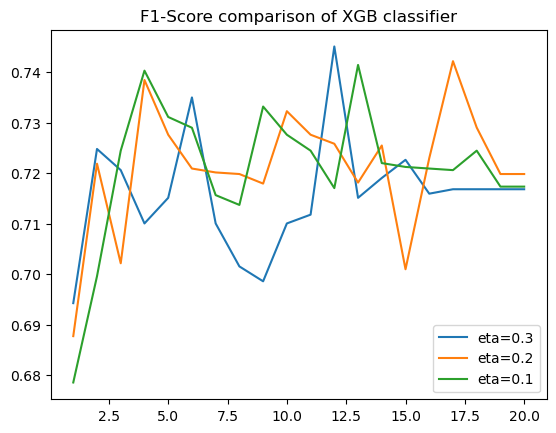

In [41]:
eta_list = [0.3,0.2,0.1]
deep_list = list(range(1,21))
for idx,m in enumerate(eta_list):
    plt.plot(deep_list,f1_val_2d_list[idx],label="eta="+str(m))
    plt.title("F1-Score comparison of XGB classifier")
plt.legend()

* Best Model eta: 0.3 ; deep: 12 ; f1_val: 0.7450980392156862

* Lets now get train this best model on full train and check it on test data

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
model = train(dv,X_full_train,y_full_train,eta = 0.3,deep = 12)
y_test_hat = predict(model,X_test)

In [43]:
f1_score_test = f1_score(y_test,y_test_hat)
print('f1_score_test:',f1_score_test)
roc_auc_score_test = roc_auc_score(y_test,y_test_hat)
print('roc_auc_score_test:',roc_auc_score_test)
accuracy_score_test = accuracy_score(y_test,y_test_hat)
print('accuracy_score_test:',accuracy_score_test)
print(classification_report(y_test,y_test_hat))

f1_score_test: 0.7358490566037735
roc_auc_score_test: 0.8340847798244427
accuracy_score_test: 0.9164677804295943
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1402
         1.0       0.76      0.71      0.74       274

    accuracy                           0.92      1676
   macro avg       0.85      0.83      0.84      1676
weighted avg       0.91      0.92      0.92      1676



## Exporting notebook to script (BentoML)

In [44]:
import bentoml
bentoml.xgboost.save_model(
    'dating_service',
    model,
    custom_objects={
        'dictVectorizer': dv
    })

Model(tag="dating_service:rdzsxjc3pcceprft", path="/Users/Arthur/bentoml/models/dating_service/rdzsxjc3pcceprft/")

#### Test

In [45]:
import json
final_features = cols_wo.copy()
final_features.remove('match')#delete target variable
request = df_clean[final_features].iloc[0].to_dict()
print(json.dumps(request, indent=2))
print('query_length:',len(final_features))

{
  "gender": "female",
  "age": 21.0,
  "age_o": 27.0,
  "importance_same_religion": 4.0,
  "pref_o_attractive": 35.0,
  "pref_o_sincere": 20.0,
  "pref_o_intelligence": 20.0,
  "pref_o_funny": 20.0,
  "pref_o_ambitious": 0.0,
  "pref_o_shared_interests": 5.0,
  "attractive_o": 6.0,
  "sinsere_o": 8.0,
  "intelligence_o": 8.0,
  "funny_o": 8.0,
  "ambitous_o": 8.0,
  "shared_interests_o": 6.0,
  "attractive_important": 15.0,
  "sincere_important": 20.0,
  "intellicence_important": 20.0,
  "funny_important": 15.0,
  "ambtition_important": 15.0,
  "shared_interests_important": 15.0,
  "attractive": 6.0,
  "sincere": 8.0,
  "intelligence": 8.0,
  "funny": 8.0,
  "ambition": 7.0,
  "attractive_partner": 6.0,
  "sincere_partner": 9.0,
  "intelligence_partner": 7.0,
  "funny_partner": 7.0,
  "ambition_partner": 6.0,
  "shared_interests_partner": 5.0,
  "sports": 9.0,
  "tvsports": 2.0,
  "exercise": 8.0,
  "dining": 9.0,
  "museums": 1.0,
  "art": 1.0,
  "hiking": 5.0,
  "gaming": 1.0,
  "c